# Requirements

In [1]:
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score

import logging
import qiskit_aer as Aer
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler 
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RealAmplitudes
# from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC

import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
import numpy as np

INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.00000 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.00000 (ms)


# Functions

## Introduction to BN and Example 1

In [2]:
def graph_example_bn(x_size=8, y_size=4):
    # Creating a directed graph for the Bayesian Network
    G = nx.DiGraph()

    # Adding nodes
    nodes = ["A", "B", "C", "D", "E"]
    G.add_nodes_from(nodes)

    # Adding directed edges (dependencies)
    edges = [("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"), ("C", "E")]
    G.add_edges_from(edges)

    # Set positions using a force-directed algorithm
    pos = nx.spring_layout(G, seed=42)  # Adding seed for consistent layout

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(x_size, y_size))

    # Draw the graph
    nx.draw(G, pos, with_labels=True, 
            node_size=2000, node_color='skyblue', 
            font_size=15, font_weight='bold', 
            edge_color="black", width=2,
            arrows=True, arrowstyle='->', arrowsize=15, ax=ax)

    # Set the title
    ax.set_title('Bayesian Network Example', fontsize=16)

    # Show the plot
    plt.show()

    # Return the figure and axes for further customization if needed
    return fig, ax


def create_example_bn1():
    array_A = [[0.7], [0.3]]
    array_B = [[0.8, 0.4], [0.2, 0.6]]
    array_C = [[0.6, 0.2], [0.4, 0.8]]
    array_D = [[0.9, 0.6, 0.7, 0.1], [0.1, 0.4, 0.3, 0.9]]   
    array_E = [[0.7, 0.1], [0.3, 0.9]]
    # Define the structure of Bayesian model
    model = BayesianNetwork([('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E')])
    # Define the conditional probability distributions (CPDs) for node A
    cpd_A = TabularCPD(variable = 'A', variable_card = 2, values = array_A)
    # Define the conditional probability distributions (CPDs) for node B
    cpd_B = TabularCPD(variable ='B', variable_card=2, values = array_B, evidence=['A'], evidence_card=[2])
    # Define the conditional probability distributions (CPDs) for node C
    cpd_C = TabularCPD(variable='C', variable_card=2, values= array_C, evidence=['A'], evidence_card=[2])
    # Define the conditional probability distributions (CPDs) for node D
    cpd_D = TabularCPD(variable = 'D', variable_card = 2,values=array_D, evidence = ['B', 'C'], evidence_card = [2, 2])
    # Define the conditional probability distributions (CPDs) for node E
    cpd_E = TabularCPD(variable = 'E', variable_card = 2, values = array_E,evidence=['C'], evidence_card=[2])
    # Adding CPDs to the model
    model.add_cpds(cpd_A, cpd_B, cpd_C, cpd_D, cpd_E)
    # Validate the model
    assert model.check_model()
    # Performing inference
    infer = VariableElimination(model)
    # Compute the probability of B given A=1
    result = infer.query(variables=['B'], evidence={'A': 1})
    return result


def create_graph_example_bn1(x_size=8, y_size=6):
    # Creating a directed graph for the Bayesian Network
    G = nx.DiGraph()

    # Adding nodes
    nodes = ["A", "B", "C", "D", "E"]
    G.add_nodes_from(nodes)

    # Adding directed edges with weights (CPT)
    edges = [
        ("A", "B", "B|A\n0.8, 0.2 | 0.4, 0.6"),
        ("A", "C", "0.6, 0.4 | 0.2, 0.8"),
        ("B", "D", "0.9, 0.1 | 0.6, 0.4"),
        ("C", "D", "0.7, 0.3 | 0.1, 0.9"),
        ("C", "E", "0.7, 0.3 | 0.1, 0.9")
    ]

    # Add edges to the graph with weights
    for src, dst, weight in edges:
        G.add_edge(src, dst, weight=weight)

    # Manually specifying node positions
    pos = {
        "A": (0, 1),
        "B": (-1, 0),
        "C": (1, 0),
        "D": (0, -1),
        "E": (2, 0)
    }

    # Node labels (CPT representations)
    node_labels = {
        "A": "A\n0.7, 0.3",
        "B": "B\n0.8, 0.2 | 0.4, 0.6",
        "C": "C\n0.6, 0.4 | 0.2, 0.8",
        "D": "D\n0.9, 0.1 | 0.6, 0.4\n0.7, 0.3 | 0.1, 0.9",
        "E": "E\n0.7, 0.3 | 0.1, 0.9"
    }

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(x_size, y_size))

    # Draw the graph
    nx.draw(
        G, pos, with_labels=True, 
        node_size=2000, node_color='skyblue', 
        font_size=12, font_weight='bold', 
        edge_color="black", width=2,
        arrows=True, arrowstyle='->', arrowsize=20, ax=ax
    )

    # Add node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    # Adding edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='green')

    # Set the title
    ax.set_title('Bayesian Network with Edge Weights', fontsize=14)

    # Show the plot
    plt.show()

    return fig, ax  # Returning fig and ax for further customization

## Creates synthetic data

In [3]:
# Creates a synthetic healthcare DataFrame
def create_healthcare_df(n_samples, # Number of samples in the DataFrame
                         p_disease, # Base rate probability of having the disease
                         p_risk, # Probability of having the risk factor
                         p1, # Probability of Symptom 1 given disease
                         p2, # Probability of Symptom 2 given disease
                         p3, # Probability of Symptom 3 given disease
                         p4, # Probability of Symptom 4 given disease
                         p_positive # Probability of a positive test given disease
                        ): 
    # Generate 'Disease' and 'Risk Factor' columns
    diseases = np.random.binomial(1, p_disease, n_samples)
    #
    q_risk = 1 - p_risk # complementary probability of risk given disease
    q1 = 1 - p1 # complementary probability of symptom 1 given disease
    q2 = 1 - p2 # complementary probability of symptom 2 given disease
    q3 = 1 - p3 # complementary probability of symptom 3 given disease
    q4 = 1 - p4 # complementary probability of symptom 4 given disease
    q_positive = 1 - p_positive
    # Generate 'RiskFactors', 'Symptoms', and 'Test Result' columns based on the presence of disease
    risk_factors = [np.random.binomial(1, p_risk if d else q_risk) for d in diseases]
    symptom1 = [np.random.binomial(1, p1 if d else q1) for d in diseases]
    symptom2 = [np.random.binomial(1, p2 if d else q2) for d in diseases]
    symptom3 = [np.random.binomial(1, p3 if d else q3) for d in diseases]
    symptom4 = [np.random.binomial(1, p4 if d else q4) for d in diseases]
    test_results = [np.random.binomial(1, p_positive if d else q_positive) for d in diseases]
    # Creating the DataFrame
    df =  pd.DataFrame({'RiskFactor': risk_factors,
                        'Disease': diseases,
                        'Symptom1': symptom1,
                        'Symptom2': symptom2,
                        'Symptom3': symptom3,
                        'Symptom4': symptom4,
                        'TestResult': test_results
                       })
    return df

## Example 2: Bayesian network

In [4]:
def run_bayesian_network(df):
    # Define the structure of the Bayesian network
    model = BayesianNetwork([
        ('RiskFactor', 'Disease'), 
        ('Disease', 'Symptom1'), 
        ('Disease', 'Symptom2'),
        ('Disease', 'Symptom3'),
        ('Disease', 'Symptom4'),
        ('Disease', 'TestResult')
    ])
    # Learn CPDs using Maximum Likelihood Estimators
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    # Perform inference
    inference = VariableElimination(model)
    # Query the probability of Disease given certain evidence
    result = inference.query(variables=['Disease'], 
                             evidence={'Symptom1': 1, 
                                       'Symptom2': 1, 
                                       'Symptom3': 1, 
                                       'Symptom4': 1
                                      })
    return result


def solve_bn_model(df):
    # Structure Learning
    hc = HillClimbSearch(df.drop(columns = 'TestResult'))
    # selecting estimate method for the bayesian model
    best_model = hc.estimate(scoring_method = BicScore(df.drop(columns = 'TestResult')))
    # Creating the Bayesian Network
    model = BayesianNetwork(best_model.edges())
    # Learning CPDs using Maximum Likelihood Estimators
    model.fit(df.drop(columns = 'TestResult'), estimator=BayesianEstimator)
    print(model)
    # Print the CPDs for each node
    for cpd in model.get_cpds():
        print("CPD of {variable}:".format(variable=cpd.variable))
        print(cpd)
    # Print the edges of the model
    print("\nEdges in the model:")
    print(model.edges())
    return model


def print_graph_bn_solved(model):
    # Allow both BayesianModel and BayesianNetwork
    if not isinstance(model, (BayesianModel, BayesianNetwork)):
        raise ValueError(f"Expected model to be a BayesianModel or BayesianNetwork, but got {type(model)}")

    if not model.nodes():
        print("The Bayesian Network has no nodes to display.")
        return

    # Create a directed graph
    nx_graph = nx.DiGraph()

    # Add nodes and edges from the Bayesian Model
    nx_graph.add_nodes_from(model.nodes())
    nx_graph.add_edges_from(model.edges())

    # Create a figure explicitly
    fig, ax = plt.subplots(figsize=(8, 6))  

    pos = nx.spring_layout(nx_graph, seed=42)  # Fix layout for better visualization
    nx.draw(nx_graph, pos, with_labels=True, node_color="lightblue", edge_color="gray", 
            node_size=2000, font_size=10, arrows=True, ax=ax)

    plt.title("Bayesian Network Graph")
    plt.show()


## Example 2: Quantum ML

In [5]:
def solving_bn_qml(df):
    # Set the logging level to WARNING to suppress info messages
    logging.getLogger('qiskit').setLevel(logging.WARNING)
    # Creates a sample of train labels as numpy array
    train_labels = np.array(df[['Disease']])
    # Creates a sample of train features as numpy array
    train_input = np.array(df[['Symptom1','Symptom2','Symptom3','Symptom4']])

    # Tell Qiskit how to simulate the circuit
    backend = Aer.get_backend('statevector_simulator')
    # Specify the quantum state that results in either 0 or 1
    initial_state = [1/np.sqrt(2), 1/np.sqrt(2)]
    classifier_report("Random PQC", run, lambda state: pqc_classify(backend, initial_state), train_input, train_labels)
    

def pqc_classify(backend, state):
    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)
    # Define state |Psi> and initialize the circuit
    qc.initialize(state, 0)
    # Measure the qubit
    qc.measure_all()
    # run the quantum circuit
    result = execute(qc, backend).result()
    # get the counts, these are either {'0': 1} or {'1': 1}
    counts = result.get_counts(qc)
    # get the bit 0 or 1
    return int(list(counts.keys())[0])

def run(f_classify, x):
    return list(map(f_classify, x))

def specificity(conf_matrix):
    # Add your implementation of specificity here
    tn, fp, _, _ = conf_matrix.ravel()
    return tn / (tn + fp)

def npv(conf_matrix):
    # Add your implementation of NPV here
    tn, _, fn, _ = conf_matrix.ravel()
    return tn / (tn + fn)

def classifier_report(name, run, classify, input_data, labels):
    cr_predictions = run(classify, input_data)
    cr_cm = confusion_matrix(labels, cr_predictions)
    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25 * (cr_precision + cr_recall + cr_specificity + cr_npv)
    cr_accuracy = accuracy_score(labels, cr_predictions)
    print(f'The accuracy of the {name} classifier is {cr_accuracy:.2f}')
    print(f'The precision score of the {name} classifier is {cr_precision:.2f}')
    print(f'The recall score of the {name} classifier is {cr_recall:.2f}')
    print(f'The specificity score of the {name} classifier is {cr_specificity:.2f}')
    print(f'The npv score of the {name} classifier is {cr_npv:.2f}')
    print(f'The information level is: {cr_level:.2f}')

## Quantum circuit example

In [6]:
def example_hadamard():
    # Set logging level to WARNING to suppress info messages
    logging.getLogger('qiskit').setLevel(logging.WARNING)
    # Create a Quantum Circuit with 2 qubits
    qc = QuantumCircuit(2)
    # Apply a Hadamard gate to the first qubit
    qc.h(0)
    # Apply a CNOT gate with the first qubit as control and the second as target
    qc.cx(0, 1)
    # Measure the qubits
    qc.measure_all()
    # Use the AerSimulator for execution
    simulator = AerSimulator()
    # Transpile the circuit for the simulator
    compiled_circuit = transpile(qc, simulator)
    # Run the compiled circuit on the simulator
    sim_result = simulator.run(compiled_circuit, shots=1000).result()
    # Get the measurement counts
    counts = sim_result.get_counts()
    return counts, qc

## Analysis

In [7]:
def cpd_df_analysis(df,a,b):
    tb = df.groupby([a,b]).agg(counter = (a,'count')).reset_index()
    tb['Probability'] = tb['counter'] / tb['counter'].sum()
    tb.drop(columns = 'counter', inplace = True)
    return tb

# Introduction

## Introduction to Bayesian networks

Bayesian Networks are graphical models that represent probabilistic relationships among a set of variables. They are a type of statistical model that uses the concepts of probability theory and graph theory to model complex relationships in data. The structure of a Bayesian Network is a DAG, where there are no circular relationships (acyclic). A Bayesian Network is composed of

* **Nodes**: Each node represents a random variable, which can be discrete or continuous. These variables can represent any kind of data, like the presence or absence of a disease, weather conditions, etc.
* **Edges**: Directed edges between nodes represent conditional dependencies. An edge from node A to node B means that the variable represented by B is dependent on the variable represented by A.

Each node in the network is associated with a probability distribution that quantifies the effects of the parents on the node. The joint probability distribution of a set of variables in a Bayesian Network can be decomposed into the product of the conditional probabilities of each variable given its parents. Bayesian Networks are widely used in various fields such as medicine, biology, engineering, artificial intelligence, and more. They are particularly useful for diagnostic systems, prediction, decision making under uncertainty, and in situations where capturing causal relationships is crucial. Inference in Bayesian Networks involves computing the posterior probability of a set of query variables given some observed evidence. This is often done using algorithms like variable elimination, belief propagation, or sampling methods.

Bayesian networks, also known as belief networks or Bayes nets, are a class of probabilistic graphical models that represent a set of variables and their conditional dependencies through a directed acyclic graph (DAG). These networks are particularly useful in modeling complex systems where the interactions between variables are best understood in terms of probabilities. 

In a Bayesian network, each node symbolizes a random variable, and the edges depict conditional dependencies. For instance, if there is an edge from node $A$ to node $B$, it implies that $A$ is a parent of $B$ and directly influences it. The essence of these dependencies is quantified using conditional probabilities. For two variables $A$ and $B$, the conditional probability of $B$ given $A$ is expressed as $P(B|A)$.

A fundamental aspect of Bayesian networks is their ability to model the joint probability distribution of a set of variables. For example, in a network comprising variables $A$, $B$, and $C$, the joint probability distribution is represented as $P(A, B, C)$. This distribution is a comprehensive representation of the probability of every possible combination of variable states in the network. Central to the functioning of Bayesian networks is Bayes' Theorem, which is articulated as:

$$ P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}$$

In this equation, $P(A|B)$ denotes the posterior probability, $P(B|A)$ is the likelihood, $P(A)$ represents the prior probability, and $P(B)$ is the evidence. Bayes' Theorem allows for the updating of our belief about the probability of $A$ given new evidence $B$. Bayesian networks simplify probability calculations using conditional independence, greatly reducing computational complexity. Key to their utility is the ability to perform inference - calculating probabilities based on evidence - for which algorithms like the Junction Tree are used. These networks are valuable in fields like medicine, finance, and AI, thanks to their prowess in modeling conditional relationships and making decisions under uncertainty. In essence, they provide a robust framework for understanding and navigating complex, probabilistic systems.

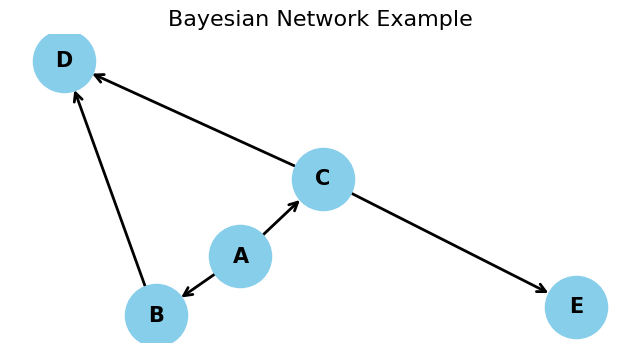

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Bayesian Network Example'}>)

In [8]:
graph_example_bn(x_size = 8, y_size = 4)

This Bayesian Network graph illustrates a set of conditional dependencies among five variables: A, B, C, D, and E. Here's an explanation of the structure:

1. **Node E**: This node does not have any parents, suggesting it is an independent variable or a root cause in this network. Its probability is not conditioned on any other variables in the graph.

2. **Node C**: This node has one parent, E. Its probability is conditional on E. The edge from E to C indicates that the occurrence of E has a direct influence on the probability of C.

3. **Node A**: This node has two parents, B and C, which means its probability is conditioned on the occurrence of B and C. There is no direct edge between B and C, which implies that B and C are conditionally independent given A.

4. **Nodes B and D**: Both of these nodes have C as a parent. Their probabilities are conditioned on C. However, B and D are conditionally independent of each other given C, as there is no direct edge between B and D.

The arrows indicate the direction of influence; for example, the arrow from C to D means the occurrence of C affects the probability of D. In terms of inference, if we have evidence about the occurrence of some variables, we can update our beliefs about the likelihood of other variables. For instance, if we know that E has occurred, we can update our belief about the likelihood of C. If we additionally learn that C has occurred, we can further refine the probabilities of A, B, and D. This kind of network is useful for probabilistic reasoning and decision-making in complex systems where the relationships between variables are known, but the outcomes are uncertain.

## Example 1: Bayesian network

The Bayesian Network graph showed bellow includes nodes with associated probabilities and conditional probabilities on the edges between nodes. To describe this network, we would need a series of probability tables that capture the relationships between these nodes. Each of these tables lists the probability of a node's state given the states of its parent nodes. For example, $P(B|A)$ is read as "the probability of B given A" and $P(C|A,B)$ is "the probability of C given A and B." These tables are foundational for performing various computations and inferences with the Bayesian Network.

For node A, which has no parents, we have a simple probability table:

| A   | P(A) |
|-----|------|
| True  | 0.7  |
| False | 0.3  |

For node B, which is dependent on A, we have:

| A   | B   | P(B\|A) |
|-----|-----|---------|
| True  | True  | 0.8     |
| True  | False | 0.2     |
| False | True  | 0.4     |
| False | False | 0.6     |

For node C, which is dependent on both A and B, we have:

| A   | B   | C   | P(C\|A,B) |
|-----|-----|-----|-----------|
| True  | True  | True  | 0.6       |
| True  | True  | False | 0.4       |
| True  | False | True  | 0.2       |
| True  | False | False | 0.8       |
| False | True  | True  | 0.1       |
| False | True  | False | 0.9       |
| False | False | True  | 0.3       |
| False | False | False | 0.7       |

For node D, which is dependent on B:

| B   | D   | P(D\|B) |
|-----|-----|---------|
| True  | True  | 0.9     |
| True  | False | 0.1     |
| False | True  | 0.6     |
| False | False | 0.4     |

For node E, which is dependent on C:

| C   | E   | P(E\|C) |
|-----|-----|---------|
| True  | True  | 0.7     |
| True  | False | 0.3     |
| False | True  | 0.1     |
| False | False | 0.9     |


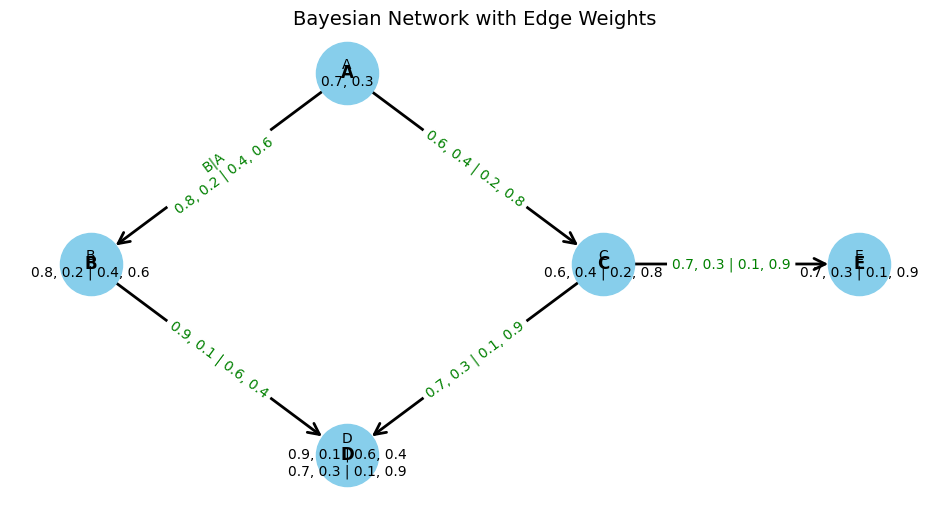

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Bayesian Network with Edge Weights'}>)

In [9]:
create_graph_example_bn1(x_size = 12, y_size = 6)

In this analysis, we utilized the `pgmpy` Python library, which is designed for probabilistic graphical models, to solve a Bayesian network problem. The function `create_example_bn1()` presumably constructed a Bayesian network and performed inference on it. As shown by the printed `result`, the inference process yielded probabilities that align with the prior probabilities we specified for the node `B`. The output suggests that `B(0)` has a probability of 0.4 and `B(1)` has a probability of 0.6. These results indicate that the Bayesian network's inference reaffirmed our initial beliefs about the system, with the calculated posterior probabilities matching the prior inputs. This outcome is a key feature of Bayesian networks; when there is no additional evidence affecting the nodes, the posterior probabilities will naturally reflect the priors that were input into the system.

In [10]:
result = create_example_bn1()
print(result)

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.4000 |
+------+----------+
| B(1) |   0.6000 |
+------+----------+


## Introduction to Quantum ML

Quantum Machine Learning is an emerging field at the intersection of quantum physics and machine learning. QML explores how quantum computing can be used to improve machine learning algorithms. Some key concepts include:

1. **Quantum Computing Basics:**
   - Quantum computing operates on quantum bits (qubits) that can exist in superpositions (both 0 and 1 simultaneously), unlike classical bits which are either 0 or 1.
   - Quantum entanglement and superposition provide the potential for quantum computers to process a vast number of possibilities simultaneously.

2. **Quantum Algorithms for Machine Learning:**
   - Quantum algorithms can potentially offer speedups for specific machine learning tasks. For example, quantum versions of gradient descent or clustering algorithms.
   - Quantum annealing is a technique used for finding global minima in optimization problems, applicable in training models.

3. **Quantum Circuits for Data Encoding:**
   - In QML, classical data is encoded into quantum states using quantum circuits. This process is crucial as it determines how well the quantum system can represent and process the data.

4. **Hybrid Quantum-Classical Models:**
   - Many current QML approaches are hybrid, where quantum algorithms are used for specific tasks (like certain calculations or data processing steps) within a larger classical algorithm.

5. **Quantum Advantage and Limitations:**
   - Quantum advantage refers to quantum algorithms performing tasks more efficiently than classical algorithms. However, this is currently limited to specific types of problems.
   - Current quantum computers, known as Noisy Intermediate-Scale Quantum (NISQ) devices, have limitations in terms of qubit count and error rates.

6. **Applications:**
   - Potential applications include drug discovery, material science, and complex system modeling, where quantum computing can analyze molecular and quantum systems natively.

Quantum machine learning is still largely theoretical and experimental, with ongoing research to understand its full capabilities and limitations. The integration of quantum computing principles into machine learning could lead to significant advancements in computational power and efficiency, but practical and widely accessible applications are still a topic of active development.

## quantum hadamard gate

In quantum computing, initializing qubits and applying basic gates like the Hadamard and CNOT are essential for building quantum algorithms. A typical example is a two-qubit circuit demonstrating superposition and entanglement. Initially, both qubits are in state $|0\rangle$. The Hadamard gate applied to the first qubit creates a superposition, $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, while the subsequent CNOT gate entangles the qubits, resulting in the state $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$. Measurement collapses this state to either $|00\rangle$ or $|11\rangle$, each with equal probability, illustrating quantum mechanics' probabilistic nature. This framework sets the stage for more complex constructs like quantum Bayesian networks, which would encode probabilistic information into quantum states.

In [11]:
# Run the function
counts, qc = example_hadamard()

# Print the measurement results
print("Measurement Outcomes:", counts)

# Draw the circuit
qc.draw(output='mpl')
plt.show()

Measurement Outcomes: {'00': 493, '11': 507}


In [12]:
print(qc)

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


{'00': 493, '11': 507}


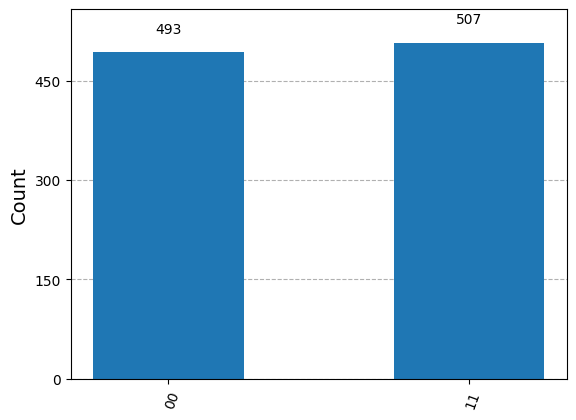

In [13]:
# Print the counts
print(counts)
plot_histogram(counts)

# Practical application: Bayesian Network vs Quantum ML

In this section, we are constructing a synthetic dataframe that simulates a healthcare scenario using a Python function called `create_healthcare_df`. This function generates a dataset with a specified number of samples (`n_samples`) representing individual patients. Each sample includes information about the presence of a disease, a risk factor, four symptoms, and a test result.

The probabilities that the function uses to generate the data are: `p_disease` for the base rate of the disease, `p_risk` for the likelihood of having a risk factor associated with the disease, `p1` through `p4` for the likelihood of exhibiting each of four symptoms given the disease, and `p_positive` for the probability of obtaining a positive result in a diagnostic test given the disease.

Using these probabilities, the function employs binomial distributions to randomly determine the presence or absence of the disease, the risk factor, the four symptoms, and the test results for each simulated patient. It accounts for the possibility that the presence of a disease increases the likelihood of associated risk factors and symptoms. The output is a pandas DataFrame where each row represents a patient and each column corresponds to one of the attributes: 'RiskFactor', 'Disease', 'Symptom1', 'Symptom2', 'Symptom3', 'Symptom4', and 'TestResult'. This synthetic data can be used for various analytical purposes, such as training predictive models, without relying on real patient data, which can be sensitive or difficult to obtain. Bellow a snipet of the dataframe:

| RiskFactor | Disease | Symptom1 | Symptom2 | Symptom3 | Symptom4 | TestResult |
|------------|---------|----------|----------|----------|----------|------------|
| 0          | 1       | 0        | 1        | 1        | 0        | 0          |
| 1          | 1       | 0        | 0        | 1        | 0        | 0          |
| ...        | ...     | ...      | ...      | ...      | ...      | ...        |
| 995        | 1       | 0        | 0        | 0        | 0        | 0          |
| 996        | 0       | 0        | 0        | 0        | 0        | 0          |
| 997        | 1       | 0        | 0        | 1        | 1        | 0          |
| 998        | 0       | 1        | 1        | 0        | 1        | 1          |
| 999        | 0       | 0        | 1        | 0        | 0        | 0          |


## Get data

In [14]:
# Example usage
df = create_healthcare_df(n_samples = 1000, # Number of samples in the DataFrame
                          p_disease = 0.25, # Base rate probability of having the disease
                          p_risk = 0.33, # Probability of having the risk factor
                          p1 = 0.70, # Probability of Symptom 1 given disease
                          p2 = 0.60, # Probability of Symptom 2 given disease
                          p3 = 0.65, # Probability of Symptom 2 given disease
                          p4 = 0.65, # Probability of Symptom 2 given disease
                          p_positive = 0.90 # Probability of a positive test given disease
                         )

## Data analysis

In [15]:
df

,RiskFactor,Disease,Symptom1,Symptom2,Symptom3,Symptom4,TestResult
0,0,1,1,0,1,1,1
1,1,0,0,1,0,0,0
2,1,0,0,1,1,0,0
3,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...
995,0,0,0,1,0,0,0
996,0,1,0,0,1,1,1
997,0,1,1,1,1,1,1
998,1,0,0,1,0,0,0


In [16]:
# Base rate probability probabilities for each feature
df.mean()

RiskFactor    0.582
Disease       0.261
Symptom1      0.415
Symptom2      0.474
Symptom3      0.452
Symptom4      0.457
TestResult    0.302
dtype: float64

In [17]:
# Probability of having the disease given a risk factor P(Disease | RiskFactor)
df.groupby('RiskFactor').agg(prob_disease = ('Disease','mean')).reset_index()

,RiskFactor,prob_disease
0,0,0.418660
1,1,0.147766


In [18]:
# Probability of having the disease given a positive test result P(Disease | TestResult)
df.groupby('TestResult').agg(prob_disease = ('Disease','mean')).reset_index()

,TestResult,prob_disease
0,0,0.042980
1,1,0.764901


In [19]:
# Probability of having the disease given the presence of Symptom1 P(Disease | Symptom1)
df.groupby('Symptom1').agg(prob_disease = ('Disease','mean')).reset_index()

,Symptom1,prob_disease
0,0,0.123077
1,1,0.455422


In [20]:
# Probability of having the disease given the presence of Symptom2 P(Disease | Symptom2)
df.groupby('Symptom2').agg(prob_disease = ('Disease','mean')).reset_index()

,Symptom2,prob_disease
0,0,0.188213
1,1,0.341772


In [21]:
# Probability of having the disease given the presence of Symptom3 P(Disease | Symptom3)
df.groupby('Symptom3').agg(prob_disease = ('Disease','mean')).reset_index()

,Symptom3,prob_disease
0,0,0.145985
1,1,0.400442


In [22]:
# Probability of having the disease given the presence of Symptom4 P(Disease | Symptom4)
df.groupby('Symptom4').agg(prob_disease = ('Disease','mean')).reset_index()

,Symptom4,prob_disease
0,0,0.162063
1,1,0.378556


In [23]:
print('P(Disease and Symptom1) =', (df['Disease'] & df['Symptom1']).mean(), '\n'
      'P(Disease and Symptom2) =', (df['Disease'] & df['Symptom2']).mean(), '\n'
      'P(Disease and Symptom3) =', (df['Disease'] & df['Symptom3']).mean(), '\n'
      'P(Disease and Symptom4) =', (df['Disease'] & df['Symptom4']).mean(), '\n'
      'P(Disease and RiskFactor) =', (df['Disease'] & df['RiskFactor']).mean(), '\n'
     )

P(Disease and Symptom1) = 0.189 
P(Disease and Symptom2) = 0.162 
P(Disease and Symptom3) = 0.181 
P(Disease and Symptom4) = 0.173 
P(Disease and RiskFactor) = 0.086 



In [24]:
# Conditional probabilities of Sympton1 given disease: P(Disease and Symptom1)
cpd_df_analysis(df, a = 'Disease', b = 'Symptom1')

,Disease,Symptom1,Probability
0,0,0,0.513
1,0,1,0.226
2,1,0,0.072
3,1,1,0.189


In [25]:
# Conditional probabilities of Sympton2 given disease: P(Disease and Symptom2)
cpd_df_analysis(df, a = 'Disease', b = 'Symptom2')

,Disease,Symptom2,Probability
0,0,0,0.427
1,0,1,0.312
2,1,0,0.099
3,1,1,0.162


In [26]:
# Conditional probabilities of Sympton3 given disease: P(Disease and Symptom3)
cpd_df_analysis(df, a = 'Disease', b = 'Symptom3')

,Disease,Symptom3,Probability
0,0,0,0.468
1,0,1,0.271
2,1,0,0.080
3,1,1,0.181


In [27]:
# Conditional probabilities of Sympton4 given disease: P(Disease and Symptom4)
cpd_df_analysis(df, a = 'Disease', b = 'Symptom4')

,Disease,Symptom4,Probability
0,0,0,0.455
1,0,1,0.284
2,1,0,0.088
3,1,1,0.173


In [28]:
# Conditional probabilities of RiskFactor given disease: P(Disease and RiskFactor)
cpd_df_analysis(df, a = 'Disease', b = 'RiskFactor')

,Disease,RiskFactor,Probability
0,0,0,0.243
1,0,1,0.496
2,1,0,0.175
3,1,1,0.086


In [29]:
# Conditional probabilities of TestResult given disease: P(Disease and TestResult)
cpd_df_analysis(df, a = 'Disease', b = 'TestResult')

,Disease,TestResult,Probability
0,0,0,0.668
1,0,1,0.071
2,1,0,0.030
3,1,1,0.231


## Run Bayesian network

In [30]:
result = run_bayesian_network(df)

In [31]:
print(result)

+------------+----------------+
| Disease    |   phi(Disease) |
+============+================+
| Disease(0) |         0.1996 |
+------------+----------------+
| Disease(1) |         0.8004 |
+------------+----------------+


## Solving the problem using Bayesian network

1. **Bayesian Network Definition:**
   - `BayesianNetwork`: This is a class from the `pgmpy` library that allows for the creation of Bayesian Networks. A Bayesian Network is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG).
   - The network is defined with nodes and edges: For example, `('RiskFactor', 'Disease')` implies that 'Disease' is conditionally dependent on 'RiskFactor'.

2. **Learning Conditional Probability Distributions (CPDs):**
   - `model.fit(df, estimator=MaximumLikelihoodEstimator)`: This line is responsible for learning the CPDs from the provided data `df` using a Maximum Likelihood Estimator. CPDs specify the probability of each variable given its parent variables in the network.

3. **Performing Inference:**
   - `VariableElimination(model)`: This is an inference algorithm used in Bayesian Networks. Variable elimination is a technique for computing the marginal distribution of a subset of variables by summing out the other variables.

4. **Querying the Network:**
   - The `inference.query()` function computes the probability distribution of the variable 'Disease' given the evidence provided (the states of 'Symptom1', 'Symptom2', 'Symptom3', and 'Symptom4').

In [32]:
model = solve_bn_model(df)

  0%|          | 0/1000000 [00:00<?, ?it/s]

BayesianNetwork with 6 nodes and 5 edges
CPD of Disease:
+------------+---------------------+-------------------+
| Symptom3   | Symptom3(0)         | Symptom3(1)       |
+------------+---------------------+-------------------+
| Disease(0) | 0.8524069028156221  | 0.599009900990099 |
+------------+---------------------+-------------------+
| Disease(1) | 0.14759309718437782 | 0.400990099009901 |
+------------+---------------------+-------------------+
CPD of Symptom1:
+-------------+--------------------+---------------------+
| Disease     | Disease(0)         | Disease(1)          |
+-------------+--------------------+---------------------+
| Symptom1(0) | 0.6935266351989211 | 0.27798861480075904 |
+-------------+--------------------+---------------------+
| Symptom1(1) | 0.3064733648010789 | 0.722011385199241   |
+-------------+--------------------+---------------------+
CPD of RiskFactor:
+---------------+--------------------+---------------------+
| Disease       | Disease(0)      

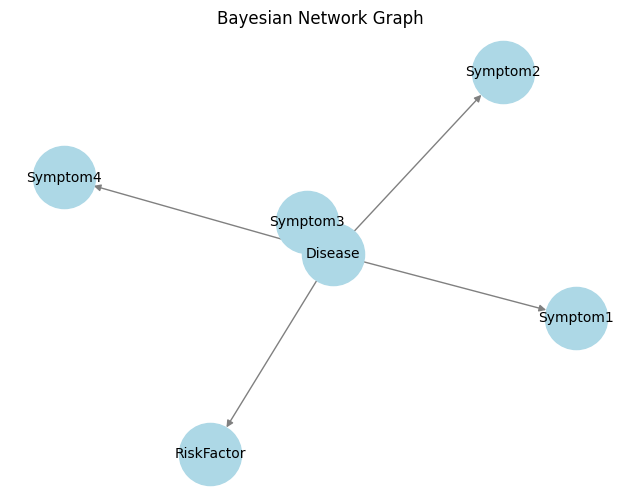

In [33]:
print_graph_bn_solved(model)

## Solving using quantum machine learning

In [47]:
def solving_bn_qml(df):
    # Set the logging level to WARNING to suppress info messages
    logging.getLogger('qiskit').setLevel(logging.WARNING)
    # Creates a sample of train labels as numpy array
    train_labels = np.array(df[['Disease']])
    # Creates a sample of train features as numpy array
    train_input = np.array(df[['Symptom1','Symptom2','Symptom3','Symptom4']])

    # Use AerSimulator instead of deprecated Aer.get_backend
    backend = AerSimulator()

    # Specify the quantum state that results in either 0 or 1
    initial_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])

    # Call classifier_report function (ensure it's correctly defined elsewhere)
    classifier_report("Random PQC", run, lambda state: pqc_classify(backend, initial_state), train_input, train_labels)

def pqc_classify(backend, state):
    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)
    # Initialize the quantum state
    qc.initialize(state, 0)
    # Measure the qubit
    qc.measure_all()

    # Use modern Qiskit method with Sampler
    sampler = Sampler()
    job = sampler.run(qc)
    result = job.result()

    # Extract the bit (0 or 1) from the probabilities
    probabilities = result.quasi_dists[0]
    prediction = max(probabilities, key=probabilities.get)  # Get the most likely outcome
    return int(prediction)

def run(f_classify, x):
    return list(map(f_classify, x))

def specificity(conf_matrix):
    # Add your implementation of specificity here
    tn, fp, _, _ = conf_matrix.ravel()
    return tn / (tn + fp)

def npv(conf_matrix):
    # Add your implementation of NPV here
    tn, _, fn, _ = conf_matrix.ravel()
    return tn / (tn + fn)

def classifier_report(name, run, classify, input_data, labels):
    cr_predictions = run(classify, input_data)
    cr_cm = confusion_matrix(labels, cr_predictions)
    cr_precision = precision_score(labels, cr_predictions, zero_division=0)
    cr_recall = recall_score(labels, cr_predictions, zero_division=0)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25 * (cr_precision + cr_recall + cr_specificity + cr_npv)
    cr_accuracy = accuracy_score(labels, cr_predictions)
    print(f'The accuracy of the {name} classifier is {cr_accuracy:.2f}')
    print(f'The precision score of the {name} classifier is {cr_precision:.2f}')
    print(f'The recall score of the {name} classifier is {cr_recall:.2f}')
    print(f'The specificity score of the {name} classifier is {cr_specificity:.2f}')
    print(f'The npv score of the {name} classifier is {cr_npv:.2f}')
    print(f'The information level is: {cr_level:.2f}')

In [50]:
solving_bn_qml(df)

C:\Users\Osvaldo\AppData\Local\Temp\ipykernel_20068\2528995621.py:35: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


ValueError: probabilities do not sum to 1

# Conclusion

In this article, I provided a brief yet thorough introduction to Bayesian networks, complete with worked examples. I built a synthetic dataframe specifically for health analytics and tackled it using a Bayesian network, utilizing the pgmpy library for Bayesian computations and the qiskit library for delving into quantum computations. An example of a simple Hadamard gate, illustrating two superposed states similar to a coin toss, was also explored.

The key takeaway is that while quantum computation is fascinating, its practical applications in simple problems aren't currently outperforming traditional algorithms, which are simpler and faster. However, this doesn't diminish the potential of quantum computing. There's significant room for growth and application in more complex problems where its unique capabilities could truly shine. This exploration into quantum computation highlights its promise and the exciting possibilities it holds for the future of complex problem-solving.

# Reference

**Formal and technical references**
* https://arxiv.org/abs/1404.0055
* https://arxiv.org/abs/1803.10520
* https://arxiv.org/abs/1611.08104
* https://arxiv.org/abs/2107.09599
* https://arxiv.org/abs/2203.02400
* https://hal.science/hal-04154072v1/file/An_optimized_Quantum_circuit_representation_of_Bayesian_networks.pdf
* https://epjquantumtechnology.springeropen.com/articles/10.1140/epjqt/s40507-023-00171-4
* https://www.sciencedirect.com/science/article/abs/pii/S0957417421002098
* https://pgmpy.org/models/bayesiannetwork.html
* [Practical Guidelines for Learning Bayesian Networks from Small Data Sets](https://www.scirp.org/journal/paperinformation.aspx?paperid=64073&utm_campaign=17209361273&utm_source=lixiaofang&utm_medium=adwords&utm_term=&utm_content=)
* [Hands-On Quantum Machine Learning With Python - Volume 1](https://www.pyqml.com/volume1?provider=medium&origin=createqbn)

**Informal references**
* https://www.researchgate.net/publication/372980693_Super_Simple_Quantum_Bayesian_Networks_Part_2
* https://towardsdatascience.com/create-a-quantum-bayesian-network-d26d7c5c4217
* https://medium.com/rejuve-io/crowdsourcing-science-with-bayes-expert-3c1be0f84e33
* https://towardsdatascience.com/how-to-create-a-quantum-bayesian-network-5b011914b03e
* https://towardsdatascience.com/create-a-quantum-bayesian-network-d26d7c5c4217
* https://en.wikipedia.org/wiki/Quantum_logic_gate
* https://en.wikipedia.org/wiki/Quantum_machine_learning#Hidden_Quantum_Markov_Models

**Other media type references**
* https://ocw.mit.edu/courses/18-435j-quantum-computation-fall-2003/pages/lecture-notes/